# Baseline Text to Text Translation : English to French

This notebook trains a sequence to sequence (seq2seq) model for English to French translation. This model will be our **baseline** model, which we will then improve upon by adding attention and other features.

---

## Import Required Libraries

We will start by importing the libraries we need for this project. You can install any missing libraries using the requirements.txt file provided or by running ``make install`` in the terminal.

In [4]:
%load_ext autoreload
%aimport utils.text_processing
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from utils.text_processing import TextProcessor

import numpy as np
import pandas as pd
import random

from keras.models import Model
from keras.layers import Input, Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed

from tensorflow.keras.preprocessing.text import Tokenizer 
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import optimizers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 200)

### Verify access to the GPU
The following test applies only if you expect to be using a GPU, e.g., while running in a cloud environment with GPU support. Run the next cell, and verify that the device_type is "GPU".

In [6]:
import tensorflow as tf
print("cuda available: ", tf.config.list_physical_devices('GPU'))

cuda available:  []


W0000 00:00:1747168192.614265   69099 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


We provide a in depth analysis of the data in the ``exploratory_analysis.ipynb`` notebook. We will not be doing any exploratory analysis in this notebook. Instead, we will focus on building our baseline model. So, let's start by importing the dataset we will be using.

In [7]:
dataset = pd.read_csv('./data/cleaned/fr_en_processed_data.csv')
dataset.head(10)

,fr,en
0,<start>il a pas pu faire grand chose qui puisse choquer cassie<end>,<start>he could not do much that could shock cassie<end>
1,<start>jpense juste qu'il aime pas qu'on s'introduise dans sa tete<end>,<start>i just think he does not like us getting into his head<end>
2,<start>par contre pour que sunny ne veulent pas que cassie voit c'est souvenir des derniere annee il a vraiment du faire des dinguerie<end>,<start>on the other hand so that sunny does not want cassie to see it is memory of the last year he really had to do some crazy things<end>
3,<start>c'est pas simplement du a son effacement du destin ils devraient etre en mesure de faire le lien mais si l'autre piaf a des bouts de pouvoir du demon de l'oubli ca expliquerait tout<end>,<start>it is not just because of its erasure of destiny they should be able to make the connection but if the other piaf has some bits of power of the demon of oblivion that would explain everythi...
4,<start>psq la le fait qu'ils oublient a chaque fois<end>,<start>psq the fact that they forget every time<end>
5,<start>possible<end>,<start>possible<end>
6,<start>il aurait pas voler des pouvoirs au demon de l'oubli<end>,<start>he would not steal powers from the demon of oblivion<end>
7,<start>le piaf de merde la<end>,<start>the shitty piaf there<end>
8,<start>par contre dcp<end>,<start>but dcp<end>
9,<start>elle sait juste que c'est lui l'anomalie<end>,<start>she just knows he is the anomaly<end>


The actual data contains over 350,000 sentence-pairs. However, to speed up training for this notebook, we will only use a small portion of the data. 

In [8]:
# TODO : Use the whole dataset (but it's too big for my computer)
# dataset = dataset.head(n=50000)
print(dataset.shape)

(11187, 2)


## Text Pre-Processing

The text pre-processing steps will be implemented in a class called ``TextPreprocessor``. This class will be used to clean and tokenize the text data. The class will also be used to convert the text to sequences and pad the sequences to a maximum length. This way we will be able to improve our model's without having to copy and paste the same code over and over again.

In [9]:
max_sequence_length = 20

In [10]:
# truncate the sentences to the max_sequence_length
dataset['en'] = dataset['en'].apply(lambda x: ' '.join(x.split()[:max_sequence_length]))
dataset['fr'] = dataset['fr'].apply(lambda x: ' '.join(x.split()[:max_sequence_length]))

dataset.head(10)

,fr,en
0,<start>il a pas pu faire grand chose qui puisse choquer cassie<end>,<start>he could not do much that could shock cassie<end>
1,<start>jpense juste qu'il aime pas qu'on s'introduise dans sa tete<end>,<start>i just think he does not like us getting into his head<end>
2,<start>par contre pour que sunny ne veulent pas que cassie voit c'est souvenir des derniere annee il a vraiment du,<start>on the other hand so that sunny does not want cassie to see it is memory of the last year
3,<start>c'est pas simplement du a son effacement du destin ils devraient etre en mesure de faire le lien mais si,<start>it is not just because of its erasure of destiny they should be able to make the connection but if
4,<start>psq la le fait qu'ils oublient a chaque fois<end>,<start>psq the fact that they forget every time<end>
5,<start>possible<end>,<start>possible<end>
6,<start>il aurait pas voler des pouvoirs au demon de l'oubli<end>,<start>he would not steal powers from the demon of oblivion<end>
7,<start>le piaf de merde la<end>,<start>the shitty piaf there<end>
8,<start>par contre dcp<end>,<start>but dcp<end>
9,<start>elle sait juste que c'est lui l'anomalie<end>,<start>she just knows he is the anomaly<end>


### Text to Sequence Conversion

To feed our data to a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Check the exploratory data analysis notebook to see the distribution of the lengths of the sentences in the dataset. Based on that, we decided to fix the maximum length of each sentence to 20 since the average length of the sentences in the dataset is around 20.

We will use the ``Tokenizer`` class from the ``tensorflow.keras.preprocessing.text`` module to tokenize the text data. The ``Tokenizer`` class will also be used to convert the text to sequences. We will use the ``pad_sequences`` function from the same module to pad the sequences to the maximum length.

In [11]:
def tokenization(lines, max_vocab_size=5000):
    tokenizer = Tokenizer(filters=' ', num_words=max_vocab_size)
    tokenizer.fit_on_texts(lines)
    return tokenizer

def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    seq = pad_sequences(seq, maxlen=length, padding='post', truncating='post')
    return seq

def decode_sequences(tokenizer, sequence):
    text = tokenizer.sequences_to_texts([sequence])[0].replace('PAD', '').strip()
    return text

def get_most_common_words(tokenizer, n=10):
    word_counts = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)
    return word_counts[:n]

In [12]:
# Tokenize the English sentences
eng_tokenizer = tokenization(dataset["en"])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

# Tokenize the French sentences
fr_tokenizer = tokenization(dataset["fr"])
fr_vocab_size = len(fr_tokenizer.word_index) + 1

In [13]:
print('English Vocabulary Size: %d' % eng_vocab_size)
print('French Vocabulary Size: %d' % fr_vocab_size)

English Vocabulary Size: 9218
French Vocabulary Size: 11195


In [14]:
print("Most common words in English: ", get_most_common_words(eng_tokenizer))
print("Most common words in French: ", get_most_common_words(fr_tokenizer))

Most common words in English:  [('the', 5758), ('is', 3458), ('to', 2530), ('of', 2270), ('it', 2179), ('a', 2138), ('not', 2067), ('i', 1901), ('that', 1740), ('he', 1354)]
Most common words in French:  [('de', 3191), ('le', 2567), ('a', 2546), ('pas', 2057), ('que', 2045), ('la', 1946), ('un', 1287), ('je', 1268), ('il', 1204), ('les', 1171)]


## Model Building

We will now split the data into train and test set for model training and evaluation, respectively. We will use the ``train_test_split`` function from the ``sklearn.model_selection`` module to split the data. We will use 10% of the data for testing and the rest for training. We will also set the ``random_state`` parameter to 42 to ensure reproducibility. 

In [15]:
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

It's time to encode the sentences. We will encode French sentences as the input sequences and English sentences as the target sequences. It will be done for both tra and test datasets.

In [16]:
# prepare training data
trainX = encode_sequences(fr_tokenizer, max_sequence_length, train_data["fr"])
trainY = encode_sequences(eng_tokenizer, max_sequence_length, train_data["en"])

# prepare validation data
testX = encode_sequences(fr_tokenizer, max_sequence_length, test_data["fr"])
testY = encode_sequences(eng_tokenizer, max_sequence_length, test_data["en"])

In [17]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((8949, 20), (8949, 20), (2238, 20), (2238, 20))

Now comes the fun part, building the model. We will build a simple Seq2Seq model for text-to-text translation. 
The model follows a simple architecture:

- Input sequence is embedded using an Embedding layer.
- The embedded sequence is processed by an LSTM layer to capture context.
- Output sequence is generated by repeating and processing with another LSTM layer.
- The Dense layer produces a probability distribution over the output vocabulary for each timestep, enabling text generation.

In [18]:
def build_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size, units=126):
    english_input = Input(shape=input_shape[1:], name="input_layer")  # the shape is (input length x 1) as batchsize excluded

    x = LSTM(units, return_sequences=True, activation="tanh", name="LSTM_layer")(english_input)
    preds = TimeDistributed(Dense(french_vocab_size, activation="softmax"), name="Dense_layer")(x)
    
    model = Model(inputs=english_input, outputs=preds, name='simple_seq2seq_model')
    return model

<img src="../images/rnn.png"
    alt="rnn"
    style="text-align: center;" />
</br>

We reshape the ``trainX`` and ``trainY`` to be 3-dimensional tensors to be used in the model. The first dimension represents the number of samples (or sentences), the second represents the length of each sequence, and the third represents the number of features in each sequence. We will use the ``trainX`` and ``trainY`` to train the model. We will use the ``testX`` and ``testY`` to evaluate the model.

In [19]:
trainX = trainX.reshape((-1, max_sequence_length, 1))
trainY = trainY.reshape((trainY.shape[0], trainY.shape[1], 1))

testX = testX.reshape((-1, max_sequence_length, 1))
testY = testY.reshape((testY.shape[0], testY.shape[1], 1))

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks. We will experiment with other optimizers in the next notebook.

We will use the ``sparse_categorical_crossentropy`` loss since we have used integers to encode the target sequences. 

In [20]:
model = build_model(trainX.shape, max_sequence_length, eng_vocab_size, 5000)

rms = optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "simple_seq2seq_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_layer (LSTM)               │ (None, 20, 126)        │        64,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_layer (TimeDistributed)   │ (None, 20, 5000)       │       635,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 699,512 (2.67 MB)

 Trainable params: 699,512 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

Note that we have used **sparse_categorical_crossentropy** as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for **30 epochs** and with a **batch size of 512**. We will also experiment with the hyperparameters in the next notebook.
We will also use **ModelCheckpoint()** to save the best model with lowest validation loss.

In [21]:
filename = '../models/baseline.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY, 
          epochs=20, batch_size=64, 
          validation_split=0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2992 - loss: 8.3954
Epoch 1: val_loss improved from inf to 7.70641, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.3004 - loss: 8.3938 - val_accuracy: 0.5401 - val_loss: 7.7064
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5392 - loss: 7.3523
Epoch 2: val_loss improved from 7.70641 to 6.24480, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.5392 - loss: 7.3492 - val_accuracy: 0.5417 - val_loss: 6.2448
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5366 - loss: 5.8947
Epoch 3: val_loss improved from 6.24480 to 4.85596, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5367 - loss: 5.8917 - val_accuracy: 0.5504 - val_loss: 4.8560
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5495 - loss: 4.5756
Epoch 4: val_loss improved from 4.85596 to 3.87565, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.5494 - loss: 4.5736 - val_accuracy: 0.5511 - val_loss: 3.8756
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5455 - loss: 3.7423
Epoch 5: val_loss improved from 3.87565 to 3.38588, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.5455 - loss: 3.7413 - val_accuracy: 0.5513 - val_loss: 3.3859
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5418 - loss: 3.3758
Epoch 6: val_loss improved from 3.38588 to 3.21425, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.5418 - loss: 3.3753 - val_accuracy: 0.5511 - val_loss: 3.2142
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5476 - loss: 3.2049
Epoch 7: val_loss improved from 3.21425 to 3.14081, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.5476 - loss: 3.2049 - val_accuracy: 0.5513 - val_loss: 3.1408
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5434 - loss: 3.1723
Epoch 8: val_loss improved from 3.14081 to 3.09771, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5435 - loss: 3.1721 - val_accuracy: 0.5539 - val_loss: 3.0977
Epoch 9/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5427 - loss: 3.1458
Epoch 9: val_loss improved from 3.09771 to 3.06773, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5428 - loss: 3.1455 - val_accuracy: 0.5541 - val_loss: 3.0677
Epoch 10/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5501 - loss: 3.0879
Epoch 10: val_loss improved from 3.06773 to 3.04549, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.5501 - loss: 3.0879 - val_accuracy: 0.5559 - val_loss: 3.0455
Epoch 11/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5529 - loss: 3.0467
Epoch 11: val_loss improved from 3.04549 to 3.02756, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.5529 - loss: 3.0469 - val_accuracy: 0.5559 - val_loss: 3.0276
Epoch 12/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5504 - loss: 3.0479
Epoch 12: val_loss improved from 3.02756 to 3.01320, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5504 - loss: 3.0479 - val_accuracy: 0.5554 - val_loss: 3.0132
Epoch 13/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5586 - loss: 2.9935
Epoch 13: val_loss improved from 3.01320 to 3.00112, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.5586 - loss: 2.9939 - val_accuracy: 0.5558 - val_loss: 3.0011
Epoch 14/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5549 - loss: 3.0088
Epoch 14: val_loss improved from 3.00112 to 2.99075, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.5549 - loss: 3.0089 - val_accuracy: 0.5576 - val_loss: 2.9907
Epoch 15/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5513 - loss: 3.0230
Epoch 15: val_loss improved from 2.99075 to 2.98114, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.5513 - loss: 3.0229 - val_accuracy: 0.5579 - val_loss: 2.9811
Epoch 16/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5531 - loss: 3.0024
Epoch 16: val_loss improved from 2.98114 to 2.97277, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.5531 - loss: 3.0024 - val_accuracy: 0.5586 - val_loss: 2.9728
Epoch 17/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5549 - loss: 2.9849
Epoch 17: val_loss improved from 2.97277 to 2.96512, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.5549 - loss: 2.9849 - val_accuracy: 0.5582 - val_loss: 2.9651
Epoch 18/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5540 - loss: 2.9846
Epoch 18: val_loss improved from 2.96512 to 2.95781, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.5540 - loss: 2.9846 - val_accuracy: 0.5587 - val_loss: 2.9578
Epoch 19/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5600 - loss: 2.9521
Epoch 19: val_loss improved from 2.95781 to 2.95097, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.5599 - loss: 2.9523 - val_accuracy: 0.5590 - val_loss: 2.9510
Epoch 20/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5550 - loss: 2.9697
Epoch 20: val_loss improved from 2.95097 to 2.94506, saving model to ../models/baseline.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.5550 - loss: 2.9697 - val_accuracy: 0.5592 - val_loss: 2.9451


In [22]:
model = load_model('../models/baseline.h5')

## Evaluation of the Model

Let's compare the training loss and the validation loss. If the validation loss is much higher than the training loss, then the model might be overfitting. We will also evaluate the model on the test set to see how well it performs on unseen data.

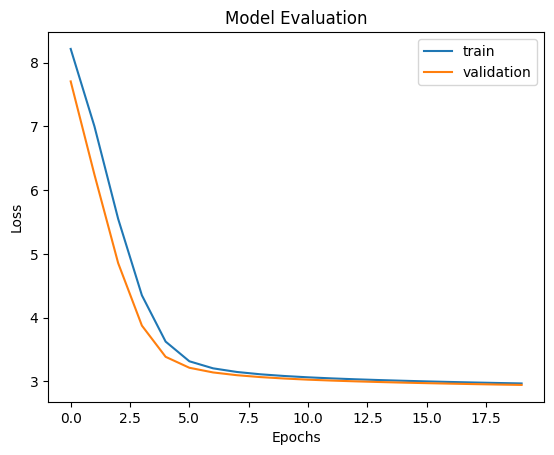

In [23]:
# Plot evaluation results
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Evaluation')
plt.show()

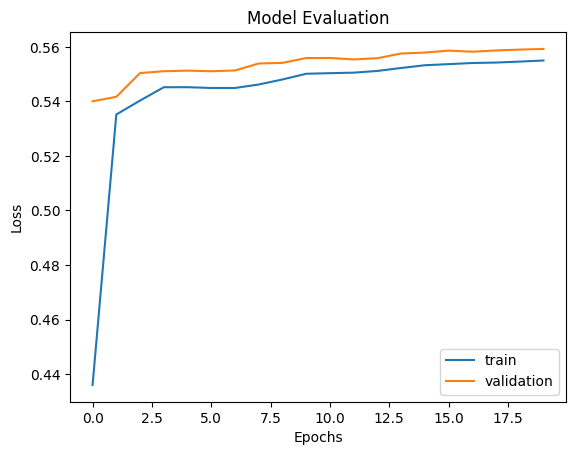

In [24]:
# Plot evaluation results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Evaluation')
plt.show()

In [25]:
evaluation = model.evaluate(testX, testY)

print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5581 - loss: 2.9678
Test Loss: 2.9797451496124268
Test Accuracy: 0.5552278757095337


In [26]:
def translate(sentence):
    sentence = encode_sequences(fr_tokenizer, max_sequence_length, [sentence])
    prediction = model.predict(sentence.reshape((sentence.shape[0], sentence.shape[1])))
    prediction = np.argmax(prediction, axis=-1)
    text = decode_sequences(eng_tokenizer, prediction[0])
    return text

In [27]:
def calculate_bleu_score(reference, candidate):
    reference = [reference.split()]
    candidate = candidate.split()
    return sentence_bleu(reference, candidate)

def evaluate_model_bleu_score(test_data):
    references = []
    candidates = []
    
    for _, row in test_data.iterrows():
        reference = row['en']
        candidate = translate(row['fr'])
        
        references.append(reference)
        candidates.append(candidate)
    
    return corpus_bleu(references, candidates)


In [28]:
# # Calculate BLEU score for a single sentence
# reference_sentence = "Hello, how are you?"
# candidate_sentence = "Bonjour, comment ça va?"
# bleu_score = calculate_bleu_score(reference_sentence, candidate_sentence)
# print("BLEU score:", bleu_score)

# # Evaluate model BLEU score on test data
# test_bleu_score = evaluate_model_bleu_score(test_data)
# print("Model BLEU score on test data:", test_bleu_score)

## Make Predictions

Now that we have our model, let's make some predictions. We will create a function called ``translate`` which will take a sentence in English as input and return the translated sentence in French. We will use the trained model to make predictions.

But before let's test on the predictions classes to see if it works.

In [29]:
size_to_predict = 10

# Make predictions on the subset
subset_to_predict = testX[:size_to_predict]
predictions = model.predict_on_batch(subset_to_predict)
predictions_classes = np.argmax(predictions, axis=-1)

# reshape the subset to predict and the testY to be able to decode them
reshapedX_subset = subset_to_predict.reshape((subset_to_predict.shape[0], subset_to_predict.shape[1]))
reshapedY_subset = testY[:size_to_predict].reshape((testY[:size_to_predict].shape[0], testY[:size_to_predict].shape[1]))

predicted_df = pd.DataFrame(columns=['french_sentence', 'actual_english_sentence', 'predicted_english_sentence'])

i = 0
for seq in predictions_classes:
    predicted_text = decode_sequences(eng_tokenizer, seq)
    original_french_sentence = decode_sequences(fr_tokenizer, reshapedX_subset[i])
    original_english_sentence = decode_sequences(eng_tokenizer, reshapedY_subset[i])
    
    predicted_df.loc[i] = [original_french_sentence, original_english_sentence, predicted_text]
    i += 1

In [30]:
predicted_df

,french_sentence,actual_english_sentence,predicted_english_sentence
0,du dieu des tempete sah<end>,<start>line of the god of tempete sah<end>,<start>i is is
1,<start>oui ca pas de doute<end>,<start>yeah no doubt<end>,<start>i is the
2,<start>bah oe sinon c'est pas drole<end>,<start>well otherwise it is not funny<end>,<start>i <start>i is is the
3,<start>psq t'as pas lu encore<end>,<start>psq you have not read kingdom yet<end>,<start>i <start>i
4,<start>tout est explique dans l'arc si jamais t'as d'autres questions hesite pas<end>,<start>everything is explained in the bow if you ever have other questions hesite not<end>,<start>i is the the
5,<start>quitte a les quand tu les en francais dans quelque jours<end>,<start>even read them again when you get them out in french in a few days<end>,<start>i the the the the the the
6,<start>justement je pense pas<end>,<start>i do not think so<end>,<start>i the the the
7,<start>ca va etre nimporte quoi vu le nombre de creature corrompu et superieur quil a en,<start>it is going to be anything given the number of corrupted and superior creatures it has in,<start>i is is the is the the
8,<start>ouais donc cest uniquement les premiers cas par le sortilege sur la lune pas les premiers portes ni meme,<start>yeah so it is only the first cases of by the exitlege on the moon not the first doors,<start>i is is the the the the the the
9,<start>deja il faut qu'elle lui trouve un nom<end>,<start>she has to find her name<end>,<start>i the the the the the the


Now let's make some predictions, with the ``translate`` function.

In [31]:
testY.shape

(2238, 20, 1)

In [33]:
from tqdm import tqdm
data = []

references = []
candidates = []

for i in tqdm(range(200)):
    textX_decoded = decode_sequences(fr_tokenizer, testX[i, : ,0])
    testY_decoded = decode_sequences(eng_tokenizer, testY[i, : ,0])
    candidate = translate(textX_decoded).replace('<end>', '').replace('<start>', '').strip()
    
    data.append({
        'Context': textX_decoded,
        'Reference': testY_decoded,
        'Candidate': candidate,
        'length': len(textX_decoded.split())
    })
    
    references.append([testY_decoded])
    candidates.append(candidate)

  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|          | 2/200 [00:00<00:13, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▎         | 5/200 [00:00<00:09, 19.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|▍         | 8/200 [00:00<00:08, 21.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|▌         | 11/200 [00:00<00:08, 22.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 14/200 [00:00<00:08, 22.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 17/200 [00:00<00:08, 21.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|█         | 20/200 [00:00<00:08, 22.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█▏        | 23/200 [00:01<00:07, 22.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 26/200 [00:01<00:08, 20.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|█▍        | 29/200 [00:01<00:08, 20.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 16%|█▌        | 32/200 [00:01<00:08, 20.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 35/200 [00:01<00:07, 21.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 38/200 [00:01<00:07, 21.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|██        | 41/200 [00:01<00:07, 21.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|██▏       | 44/200 [00:02<00:07, 22.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▎       | 47/200 [00:02<00:06, 22.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▌       | 50/200 [00:02<00:06, 21.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▋       | 53/200 [00:02<00:06, 21.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██▊       | 56/200 [00:02<00:06, 22.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|██▉       | 59/200 [00:02<00:06, 22.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 62/200 [00:02<00:06, 22.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███▎      | 65/200 [00:02<00:05, 22.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|███▍      | 68/200 [00:03<00:05, 22.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▌      | 71/200 [00:03<00:05, 23.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 74/200 [00:03<00:05, 22.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 77/200 [00:03<00:05, 22.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|████      | 80/200 [00:03<00:05, 21.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 83/200 [00:03<00:05, 21.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|████▎     | 86/200 [00:03<00:05, 22.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▍     | 89/200 [00:04<00:04, 22.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▌     | 92/200 [00:04<00:04, 23.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|████▊     | 95/200 [00:04<00:04, 22.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 49%|████▉     | 98/200 [00:04<00:04, 22.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|█████     | 101/200 [00:04<00:04, 22.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|█████▏    | 104/200 [00:04<00:04, 21.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▎    | 107/200 [00:04<00:04, 21.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 55%|█████▌    | 110/200 [00:05<00:04, 21.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|█████▋    | 113/200 [00:05<00:04, 20.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 116/200 [00:05<00:03, 21.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|█████▉    | 119/200 [00:05<00:03, 22.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 122/200 [00:05<00:03, 21.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|██████▎   | 125/200 [00:05<00:03, 21.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 64%|██████▍   | 128/200 [00:05<00:03, 21.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 66%|██████▌   | 131/200 [00:05<00:03, 22.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|██████▋   | 134/200 [00:06<00:03, 21.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 137/200 [00:06<00:02, 22.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|███████   | 140/200 [00:06<00:02, 21.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 143/200 [00:06<00:02, 21.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|███████▎  | 146/200 [00:06<00:02, 22.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 74%|███████▍  | 149/200 [00:06<00:02, 21.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 76%|███████▌  | 152/200 [00:06<00:02, 20.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████▊  | 155/200 [00:07<00:02, 21.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 79%|███████▉  | 158/200 [00:07<00:01, 21.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|████████  | 161/200 [00:07<00:01, 20.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|████████▏ | 164/200 [00:07<00:01, 21.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 84%|████████▎ | 167/200 [00:07<00:01, 22.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|████████▌ | 170/200 [00:07<00:01, 21.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 86%|████████▋ | 173/200 [00:07<00:01, 21.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 88%|████████▊ | 176/200 [00:08<00:01, 20.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████▉ | 179/200 [00:08<00:00, 21.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|█████████ | 182/200 [00:08<00:00, 22.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████▎| 185/200 [00:08<00:00, 20.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▍| 188/200 [00:08<00:00, 20.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 96%|█████████▌| 191/200 [00:08<00:00, 21.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 97%|█████████▋| 194/200 [00:08<00:00, 20.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 197/200 [00:09<00:00, 20.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|██████████| 200/200 [00:09<00:00, 21.69it/s]


In [34]:
# split into small dataset based on the sentences length
length_ranges = [(1, 5), (6, 10), (11, 15), (16, 20), (21, 30), (31, 40), (41, 60), (61, float('inf'))]

small_datasets = {}
for min_len, max_len in length_ranges:
    filtered_examples = [example for example in data if example['length'] >= min_len and example['length'] <= max_len]
    small_datasets[f'dataset_{min_len}_{max_len}'] = filtered_examples

samples_per_range = []
for key, dataset in small_datasets.items():
    samples_per_range.append(len(dataset))
    print(f"{key}: {len(dataset)} samples")

dataset_1_5: 56 samples
dataset_6_10: 70 samples
dataset_11_15: 30 samples
dataset_16_20: 38 samples
dataset_21_30: 0 samples
dataset_31_40: 0 samples
dataset_41_60: 0 samples
dataset_61_inf: 0 samples


In [35]:
def compute_corpus_bleu(references, candidates):
    if len(references) != len(candidates):
        raise ValueError('The number of references and candidates must be the same :', len(references), len(candidates))
    
    if len(references) == 0: return 0.0
    
    reference_tokens = [[ref] for ref in references]
    return corpus_bleu(reference_tokens, candidates)

In [36]:
bleu_scores = []
for key, dataset in small_datasets.items():
    refs = [example['Reference'] for example in dataset]
    cands = [example['Candidate'] for example in dataset]
    
    corpus_bleu_score = compute_corpus_bleu(refs, cands)
    bleu_scores.append(corpus_bleu_score)
    
    print(f"{key}: {corpus_bleu_score:.4f}")

dataset_1_5: 0.0016
dataset_6_10: 0.0216
dataset_11_15: 0.0276
dataset_16_20: 0.0426
dataset_21_30: 0.0000
dataset_31_40: 0.0000
dataset_41_60: 0.0000
dataset_61_inf: 0.0000


In [37]:
overall_bleu_score = corpus_bleu(references, candidates)
overall_bleu_score

0.02420300385780067

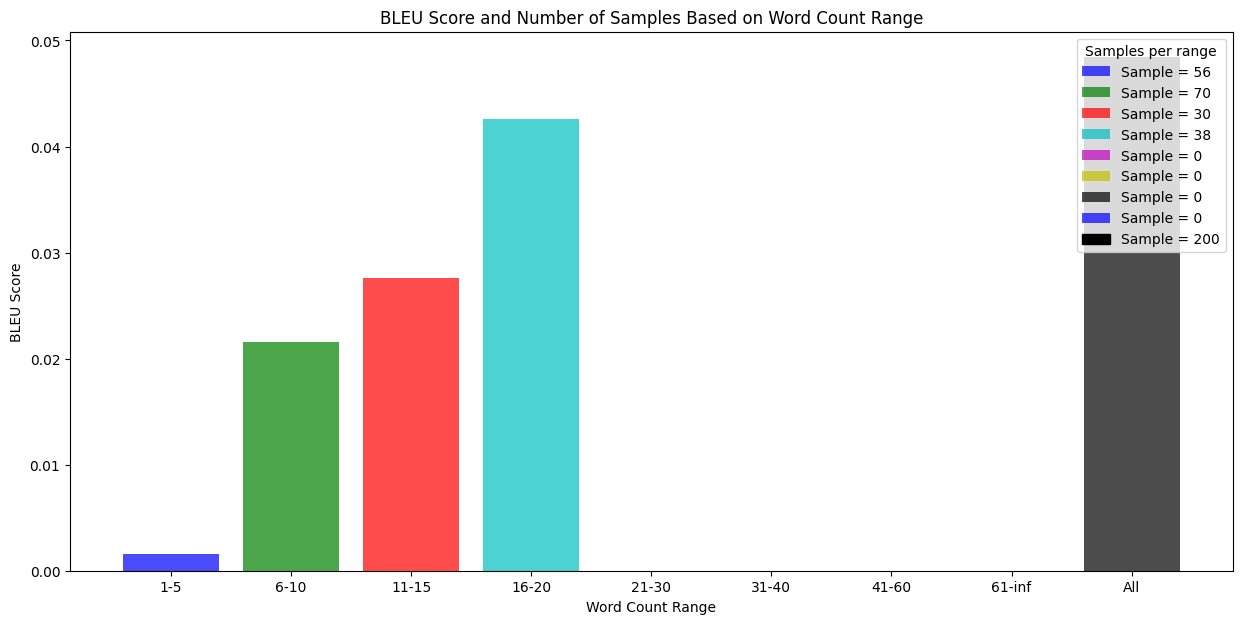

In [38]:
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 7))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # List of colors for each bar
bar_plot = plt.bar([f'{start}-{end}' for start, end in length_ranges], bleu_scores, color=colors, alpha=0.7, label='BLEU Score')

# Add "All" bar with legend
all_bar = plt.bar("All", overall_bleu_score * 2, color='k', alpha=0.7)

# Create a dummy handle for the "All" bar
all_patch = mpatches.Patch(color='k', label=f'Sample = {len(candidates)}')
legend_labels = [f'Sample = {value}' for value in samples_per_range]

# Include the dummy handle in the legend
plt.legend(handles=[*bar_plot, all_patch], labels=legend_labels + [f'Sample = {len(candidates)}'], loc='upper right', title='Samples per range')

plt.xlabel('Word Count Range')
plt.ylabel('BLEU Score')

plt.title('BLEU Score and Number of Samples Based on Word Count Range')

plt.show()

In [39]:
translate("<start> je suis un chat <end>")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


'<start>i is the'